In [1]:
#Basic packages always been used
import pandas as pd
import numpy as np
import sktime
import matplotlib.pyplot as plt
# Function for spilting training & testing data set
from sklearn.model_selection import train_test_split,TimeSeriesSplit,GridSearchCV
# ALgorithm
from sklearn import tree
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
# Functions for evaluation
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import plot_roc_curve, roc_auc_score, roc_curve
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sktime.performance_metrics.forecasting import mean_absolute_scaled_error,median_relative_absolute_error

In [2]:
df = pd.read_csv("nasdaq2000~2023.csv")

In [3]:
# Symmetric Mean Absolute Percentage Error (SMAPE)
def SMAPE_calulate(y_true, y_pred):
    n = len(y_true)
    SMAPE=(100 / n) * np.sum(2 * np.abs(y_pred - y_true) / (np.abs(y_pred) + np.abs(y_true)))
    return SMAPE

# Relative Absolute Error (RAE)
def RAE_calculate(y_true, y_pred):
    abs_errors = np.abs(y_true - y_pred)
    denominator = np.sum(np.abs(y_true - np.mean(y_true)))
    RAE=np.sum(abs_errors/denominator)
    return RAE

# Mean Relative Absolute Error (MRAE)
def MRAE_calculate(y_true, y_pred):
    n=len(y_true)
    abs_errors = np.abs(y_true - y_pred)
    denominator = np.sum(np.abs(y_true - np.mean(y_true)))
    RAE=np.sum(abs_errors/denominator)
    MRAE=RAE/n
    return MRAE

# Median Relative Absolute Error (MdRAE) comparing with benchmark
# Note: By default, the bench value is the mean of actual value
def MdRAE_calculate(y_true, y_pred, bench=None):
    if bench==None:
        bench=np.mean(y_true)
        MdRAE=np.median(np.abs(y_true - y_pred)/np.abs(y_true - bench))
        return MdRAE,bench
    else:
        MdRAE=np.median(np.abs(y_true - y_pred)/np.abs(y_true - bench))
        return MdRAE
    
# Relative Squared Error (RSE) & Root Relative Squared Error (RRSE)
def RSE_calculate(y_true, y_pred, Root=False):
    mse = np.mean((y_true - y_pred)**2)
    denominator = np.var(y_true)
    RSE=mse/denominator
    
    if Root==True:
        return np.sqrt(RSE)
    else:
        return RSE

In [4]:
new_df=df.iloc[:,[0,4]].copy()
new_df.head()

,Date,Close
0,2000/1/3,4131.149902
1,2000/1/4,3901.689941
2,2000/1/5,3877.540039
3,2000/1/6,3727.129883
4,2000/1/7,3882.620117


In [5]:
# Create 3 lags
new_df['Lag_1']=new_df['Close'].shift(1).copy()
new_df['Lag_2']=new_df['Close'].shift(2).copy()
new_df['Lag_3']=new_df['Close'].shift(3).copy()
new_df.head()

,Date,Close,Lag_1,Lag_2,Lag_3
0,2000/1/3,4131.149902,NaN,NaN,NaN
1,2000/1/4,3901.689941,4131.149902,NaN,NaN
2,2000/1/5,3877.540039,3901.689941,4131.149902,NaN
3,2000/1/6,3727.129883,3877.540039,3901.689941,4131.149902
4,2000/1/7,3882.620117,3727.129883,3877.540039,3901.689941


In [6]:
# Drop out missing values and rest index
clean_df=new_df.dropna(axis=0, how='any').copy()
clean_df=clean_df.reset_index(drop=True)
clean_df

,Date,Close,Lag_1,Lag_2,Lag_3
0,2000/1/6,3727.129883,3877.540039,3901.689941,4131.149902
1,2000/1/7,3882.620117,3727.129883,3877.540039,3901.689941
2,2000/1/10,4049.669922,3882.620117,3727.129883,3877.540039
3,2000/1/11,3921.189941,4049.669922,3882.620117,3727.129883
4,2000/1/12,3850.020020,3921.189941,4049.669922,3882.620117
...,...,...,...,...,...
5880,2023/5/22,12720.780270,12657.900390,12688.839840,12500.570310
5881,2023/5/23,12560.250000,12720.780270,12657.900390,12688.839840
5882,2023/5/24,12484.160160,12560.250000,12720.780270,12657.900390
5883,2023/5/25,12698.089840,12484.160160,12560.250000,12720.780270


In [7]:
x = clean_df.drop(['Date', 'Close'],axis=1).copy()
x.head()

,Lag_1,Lag_2,Lag_3
0,3877.540039,3901.689941,4131.149902
1,3727.129883,3877.540039,3901.689941
2,3882.620117,3727.129883,3877.540039
3,4049.669922,3882.620117,3727.129883
4,3921.189941,4049.669922,3882.620117


In [8]:
y = clean_df['Close'].copy()
y.head()

0    3727.129883
1    3882.620117
2    4049.669922
3    3921.189941
4    3850.020020
Name: Close, dtype: float64

In [9]:
train_data=clean_df.iloc[0:4704,:].copy()
train_data

,Date,Close,Lag_1,Lag_2,Lag_3
0,2000/1/6,3727.129883,3877.540039,3901.689941,4131.149902
1,2000/1/7,3882.620117,3727.129883,3877.540039,3901.689941
2,2000/1/10,4049.669922,3882.620117,3727.129883,3877.540039
3,2000/1/11,3921.189941,4049.669922,3882.620117,3727.129883
4,2000/1/12,3850.020020,3921.189941,4049.669922,3882.620117
...,...,...,...,...,...
4699,2018/9/11,7972.470215,7924.160156,7902.540039,7922.729980
4700,2018/9/12,7954.229980,7972.470215,7924.160156,7902.540039
4701,2018/9/13,8013.709961,7954.229980,7972.470215,7924.160156
4702,2018/9/14,8010.040039,8013.709961,7954.229980,7972.470215


In [10]:
test_data=clean_df.iloc[4704:5884,:].copy()
test_data

,Date,Close,Lag_1,Lag_2,Lag_3
4704,2018/9/18,7956.109863,7895.790039,8010.040039,8013.709961
4705,2018/9/19,7950.040039,7956.109863,7895.790039,8010.040039
4706,2018/9/20,8028.229980,7950.040039,7956.109863,7895.790039
4707,2018/9/21,7986.959961,8028.229980,7950.040039,7956.109863
4708,2018/9/24,7993.250000,7986.959961,8028.229980,7950.040039
...,...,...,...,...,...
5879,2023/5/19,12657.900390,12688.839840,12500.570310,12343.049810
5880,2023/5/22,12720.780270,12657.900390,12688.839840,12500.570310
5881,2023/5/23,12560.250000,12720.780270,12657.900390,12688.839840
5882,2023/5/24,12484.160160,12560.250000,12720.780270,12657.900390


In [11]:
new_train_data = clean_df.drop(['Date', 'Close'],axis=1).copy()
new_test_data = clean_df['Close'].copy()

In [12]:
train_mse_list = []
train_mape_list = []
train_rmse_list = []
train_smape_list = []
train_mae_list = []
train_mdrae_list = []

test_mse_list = []
test_mape_list = []
test_rmse_list = []
test_smape_list = []
test_mae_list = []
test_mdrae_list = []



x_train,x_test,y_train,y_test=train_test_split(new_train_data,new_test_data,test_size=0.2,shuffle=False)
clf1 = KNeighborsRegressor()
param = [{'n_neighbors': np.arange(1,31), 'metric':['euclidean', 'manhattan', 'minkowski']}]
cv_inner=TimeSeriesSplit(n_splits=3)
model = GridSearchCV(clf1, param_grid=param,
                           scoring='neg_root_mean_squared_error',
                           cv=cv_inner,
                           refit=True)
model.fit(x_train, y_train)
training_score=model.best_score_
best_parameter=model.best_params_
train_model=model.best_estimator_

print('training score:',training_score)
print('best parameter:',best_parameter)

train_pred = model.predict(x_train)
y_pred_benchmark = train_pred*1.1

train_mse=round(mean_squared_error(y_train,train_pred, squared=True), 4)
train_mse_list.append(round(mean_squared_error(y_train,train_pred,squared=True),4))

train_mape=round(mean_absolute_percentage_error(y_train,train_pred),4)
train_mape_list.append(round(mean_absolute_percentage_error(y_train,train_pred),4))

train_rmse=round(mean_squared_error(y_train,train_pred, squared=False),4)
train_rmse_list.append(round(mean_squared_error(y_train,train_pred, squared=False),4))

train_smape=round(2*np.mean(np.abs(train_pred-y_train)/(np.abs(train_pred)+np.abs(y_train)))*100,4)
train_smape_list.append(round(2*np.mean(np.abs(train_pred-y_train)/(np.abs(train_pred)+np.abs(y_train)))*100,4))

train_mae=round(mean_absolute_error(y_train,train_pred),4)
train_mae_list.append(round(mean_absolute_error(y_train,train_pred),4))

train_mdrae=round(round(median_relative_absolute_error(y_train,train_pred,y_pred_benchmark=y_pred_benchmark), 4))
train_mdrae_list.append(round(median_relative_absolute_error(y_train,train_pred,y_pred_benchmark=y_pred_benchmark),4))
#print result
print('train_mse:',train_mse)
print('train_mape:',train_mape)
print('train_rmse:',train_rmse)
print('train_smape:',train_smape)
print('train_mae:',train_mae)
print('train_mrae:',train_mdrae)
print('')


test_pred = model.predict(x_test)
y_pred_benchmark = test_pred*1.1

test_mse=round(mean_squared_error(y_test,test_pred, squared=True), 4)
test_mse_list.append(round(mean_squared_error(y_test,test_pred,squared=True),4))

test_mape=round(mean_absolute_percentage_error(y_test,test_pred),4)
test_mape_list.append(round(mean_absolute_percentage_error(y_test,test_pred),4))

test_rmse=round(mean_squared_error(y_test,test_pred, squared=False),4)
test_rmse_list.append(round(mean_squared_error(y_test,test_pred, squared=False),4))

test_smape=round(2*np.mean(np.abs(test_pred-y_test)/(np.abs(test_pred)+np.abs(y_test)))*100,4)
test_smape_list.append(round(2*np.mean(np.abs(test_pred-y_test)/(np.abs(test_pred)+np.abs(y_test)))*100,4))

test_mae=round(mean_absolute_error(y_test,test_pred),4)
test_mae_list.append(round(mean_absolute_error(y_test,test_pred),4))

test_mdrae=round(round(median_relative_absolute_error(y_test,test_pred,y_pred_benchmark=y_pred_benchmark), 4))
test_mdrae_list.append(round(median_relative_absolute_error(y_test,test_pred,y_pred_benchmark=y_pred_benchmark),4))
#print result
print('test_mse:',test_mse)
print('test_mape:',test_mape)
print('test_rmse:',test_rmse)
print('test_smape:',test_smape)
print('test_mae:',test_mae)
print('test_mdrae:',test_mdrae)

training score: -446.6570112669799
best parameter: {'metric': 'manhattan', 'n_neighbors': 12}
train_mse: 2117.4699
train_mape: 0.0109
train_rmse: 46.016
train_smape: 1.0834
train_mae: 30.9719
train_mrae: 0

test_mse: 15808759.7063
test_mape: 0.2444
test_rmse: 3976.0231
test_smape: 29.9119
test_mae: 3124.1876
test_mdrae: 1


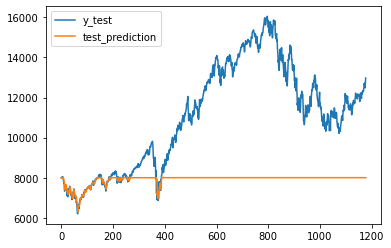

In [13]:
y_test = y_test.reset_index(drop = True)
y_test.head()
fig = plt.figure()
plt.plot(y_test, label='y_test')
plt.plot(test_pred, label='test_prediction')
plt.legend(loc='best')

In [20]:
# X test
x_forecast_test=test_data.drop(['Date','Close'],axis=1).copy()
# Y test
y_forecast_test=test_data['Close'].copy()

In [21]:
prediction=np.round((model.predict_on_batch(x_forecast_test)),2)
pred_values=[]
for i in range(0,len(prediction)):
    value=prediction[i][0]
    pred_values.append(value)

AttributeError: 'GridSearchCV' object has no attribute 'predict_on_batch'

In [19]:
results=pd.DataFrame({'Y_test_true':test_data,'Y_test_predict':pred_values})
results['count'] = generate_index(amount=len(test_data))
results

ValueError: If using all scalar values, you must pass an index

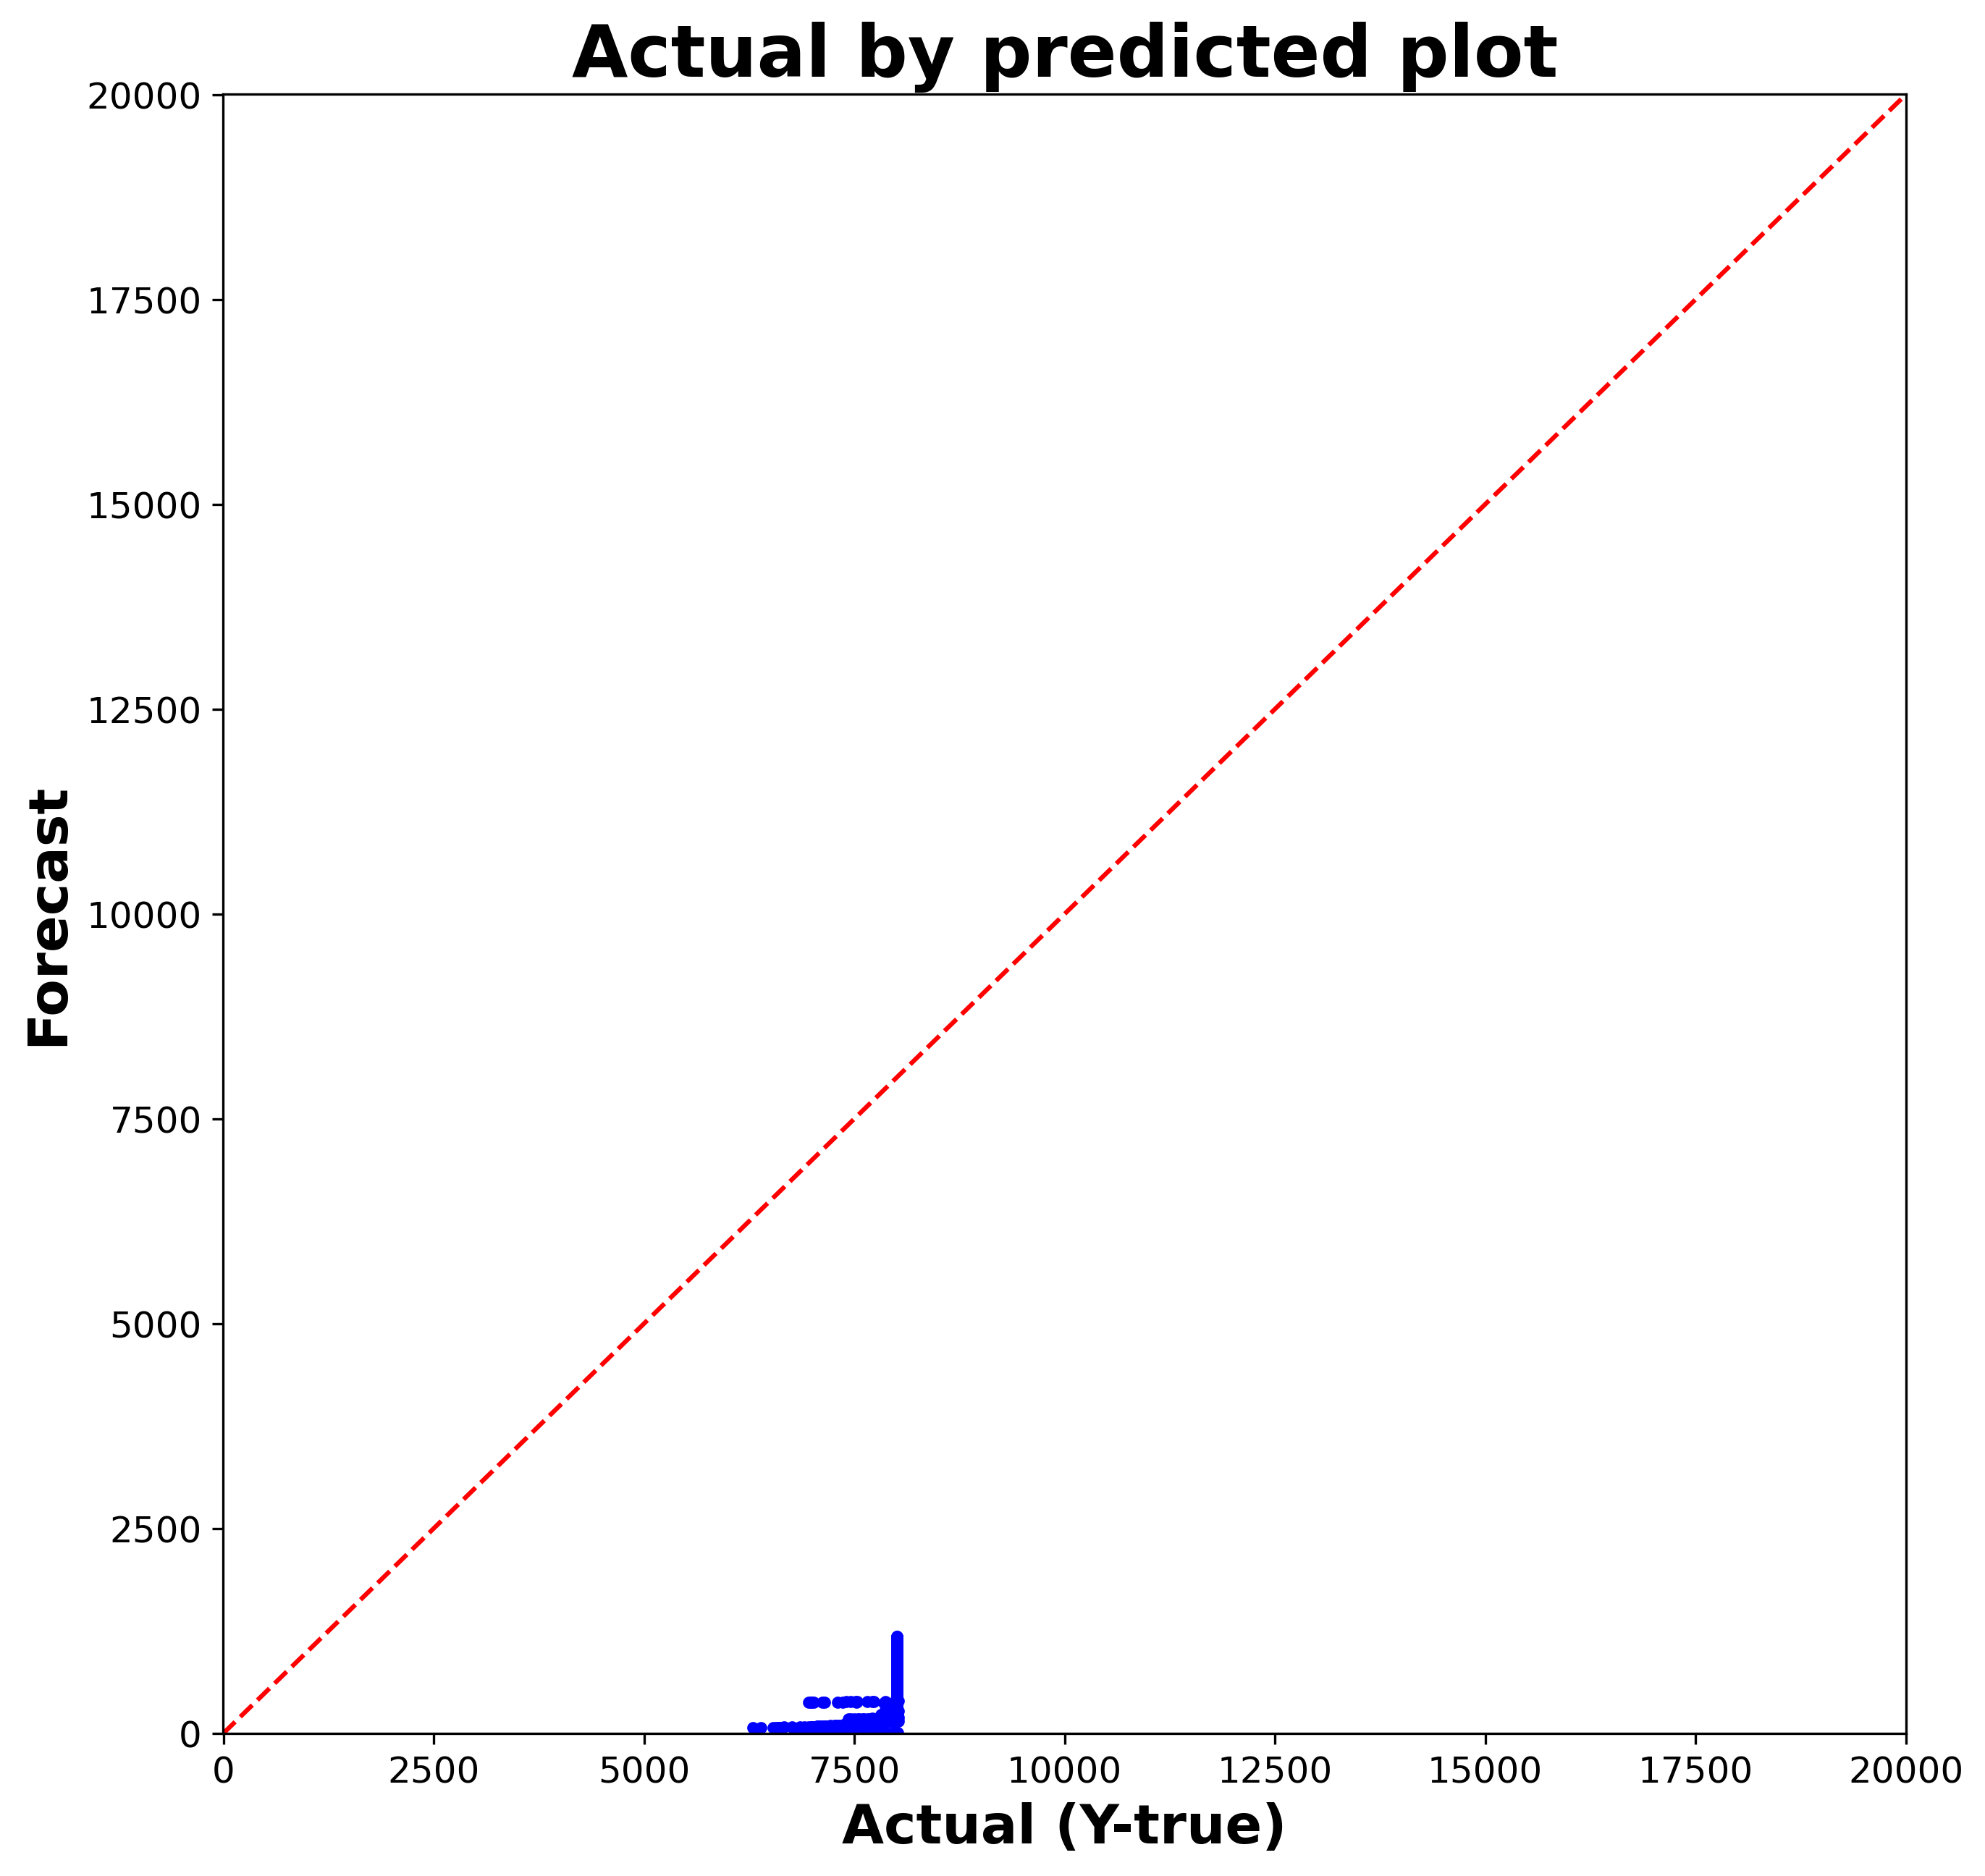

In [18]:
# Lock the scale of axis by Y_true
max_value=20000+5
min_value=0-5

# Figure setting
plt.figure(figsize=(10,10),dpi=300)
plt.title('Actual by predicted plot',weight='bold',fontsize=24)
plt.xlabel('Actual (Y-true)',fontsize=18,weight='bold')
plt.ylabel('Forecast',fontsize=18,weight='bold')

# Perfect model reference line
plt.plot([min_value,max_value], [min_value,max_value], linestyle='--',color='red')

# Actual by predicted plot
plt.scatter(results.iloc[:,1],results.iloc[:,2],marker='.',color='blue')

# Set the axis
plt.ylim(0-5,max_value)
plt.xlim(0-5,max_value)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()